In [43]:
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU


MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 20106
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [44]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [45]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("preprocessed_data.csv")
sentences = train["case_text"].values
possible_labels = ["misconduct"]
targets = train[possible_labels].values

Loading in comments...


In [46]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [47]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 20106
min sequence length: 168
median sequence length: 1542


In [48]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 34782 unique tokens.


In [49]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (624, 20106)


In [11]:
data

array([[   0,    0,    0, ...,  363, 8745,  121],
       [   0,    0,    0, ...,  163, 4526,  121],
       [   0,    0,    0, ...,  327,  105,  121],
       ...,
       [   0,    0,    0, ..., 8116, 1277,  121],
       [   0,    0,    0, ...,  942,  163,  121],
       [   0,    0,    0, ...,  347, 4748,  121]], dtype=int32)

In [51]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [52]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [14]:
# print('Building model...')

# # create an LSTM network with a single LSTM
# input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
# x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
# # x = Bidirectional(LSTM(15, return_sequences=True))(x)
# x = GlobalMaxPool1D()(x)
# output = Dense(len(possible_labels), activation="sigmoid")(x)

# model = Model(input_, output)
# model.compile(
#   loss='binary_crossentropy',
#   optimizer=Adam(lr=0.01),
#   metrics=['accuracy']
# )

In [53]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(32, return_sequences=True)(x)
# x = LSTM(10)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

Building model...


Training model...
Train on 499 samples, validate on 125 samples
Epoch 1/5
499/499 [==============================] - 192s 384ms/step - loss: 0.6338 - acc: 0.6072 - val_loss: 0.5435 - val_acc: 0.7680
Epoch 2/5
499/499 [==============================] - 151s 302ms/step - loss: 0.5662 - acc: 0.7435 - val_loss: 0.5226 - val_acc: 0.7680
Epoch 3/5
499/499 [==============================] - 122s 245ms/step - loss: 0.5438 - acc: 0.7435 - val_loss: 0.5178 - val_acc: 0.7680
Epoch 4/5
499/499 [==============================] - 140s 280ms/step - loss: 0.5236 - acc: 0.7435 - val_loss: 0.4979 - val_acc: 0.7680
Epoch 5/5
499/499 [==============================] - 144s 289ms/step - loss: 0.5088 - acc: 0.7435 - val_loss: 0.4830 - val_acc: 0.7680


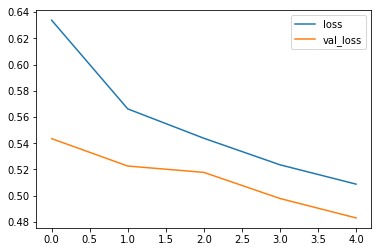

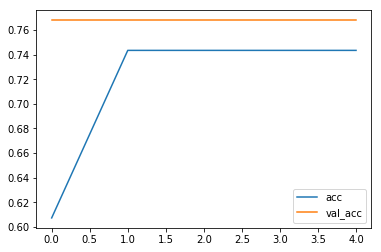

0.8071714016830562


In [54]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

p = model.predict(data)
aucs = []
for j in range(targets.shape[1]):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20106)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20106, 50)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20106, 32)         10624     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,010,657
Trainable params: 10,657
Non-trainable params: 1,000,000
_________________________________________________________________


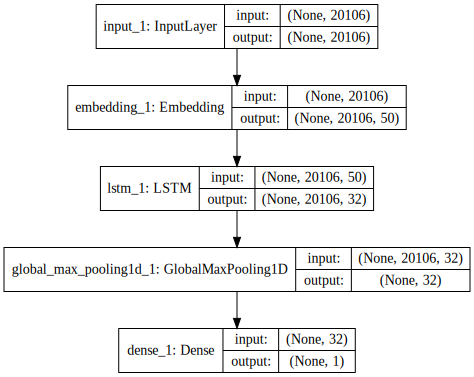

In [56]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [34]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_lstm.png', show_shapes=True)